In [2]:
import scanpy as sc
import scvi

# Step 1: Load data
adata = sc.read_h5ad("pbmc68k_with_labels.h5ad")
adata.obs["cell_type"] = adata.obs["cell_type"].astype(str).fillna("Unknown")

/root/miniconda3/envs/scvi/lib/python3.9/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [3]:
# Step 2: Setup SCVI without labels
scvi.model.SCVI.setup_anndata(adata, labels_key="cell_type")

/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(


In [4]:
# Step 3: Train SCVI
model = scvi.model.SCVI(adata)
model.train(max_epochs=100)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [34:15<00:00, 20.74s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.07e+3] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [34:15<00:00, 20.56s/it, v_num=1, train_loss_step=2.1e+3, train_loss_epoch=2.07e+3]


In [5]:
# ✅ Step 4: Setup SCANVI with labels
scvi.model.SCANVI.setup_anndata(
    adata, 
    labels_key="cell_type", 
    unlabeled_category="Unknown"
)

/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


In [6]:
# ✅ Step 5: Convert from trained SCVI → SCANVI
scanvi = scvi.model.SCANVI.from_scvi_model(model, unlabeled_category="Unknown")
scanvi.train(max_epochs=100)

/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:116: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_dataframe_field.py:186: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scvi/data/fields/_scanvi.py:56: UserWarning: Category 6 in adata.obs['_scvi_labels'] has fewer than 3 cells. Models may not train properly.
  mapping = _make_column_categorical(


INFO     Training for 100 epochs.                                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/root/miniconda3/envs/scvi/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 100/100: 100%|██████████| 100/100 [1:10:59<00:00, 41.93s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 100/100: 100%|██████████| 100/100 [1:10:59<00:00, 42.59s/it, v_num=1, train_loss_step=2.07e+3, train_loss_epoch=2.06e+3]


In [7]:
# Step 6: Predict
adata.obs["scanvi_labels"] = scanvi.predict()
adata.write("pbmc68k_scanvi_output.h5ad")

In [10]:
# 如果没有 UMAP，可以先生成（你预处理阶段应该已有）
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/root/miniconda3/envs/scvi/lib/python3.9/site-packages/scanpy/tools/_utils.py:41: UserWarning: You’re trying to run this on 23614 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


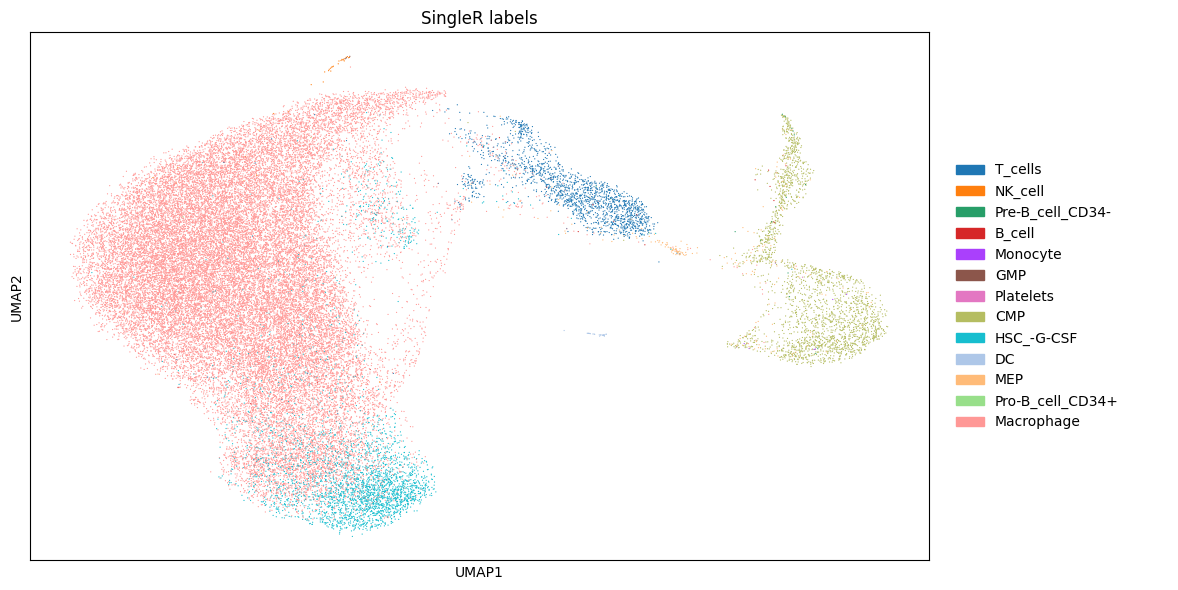

In [13]:

import scanpy as sc
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [4, 1]})


sc.pl.umap(
    adata,
    color="cell_type",  # SingleR 预测的标签
    title="SingleR labels",
    ax=axs[0],
    show=False,
    legend_loc=None  # 取消默认图注
)


import pandas as pd
import matplotlib.patches as mpatches


label_colormap = adata.uns["cell_type_colors"]
label_names = adata.obs["cell_type"].unique().tolist()


patches = [
    mpatches.Patch(color=label_colormap[i], label=label_names[i])
    for i in range(len(label_names))
]

axs[1].axis("off")  
axs[1].legend(
    handles=patches,
    loc="center left",
    frameon=False,
    fontsize=10
)


plt.tight_layout()
plt.savefig("SingleR_umap_with_legend.png", dpi=300)  # 也可改为 .pdf
plt.show()


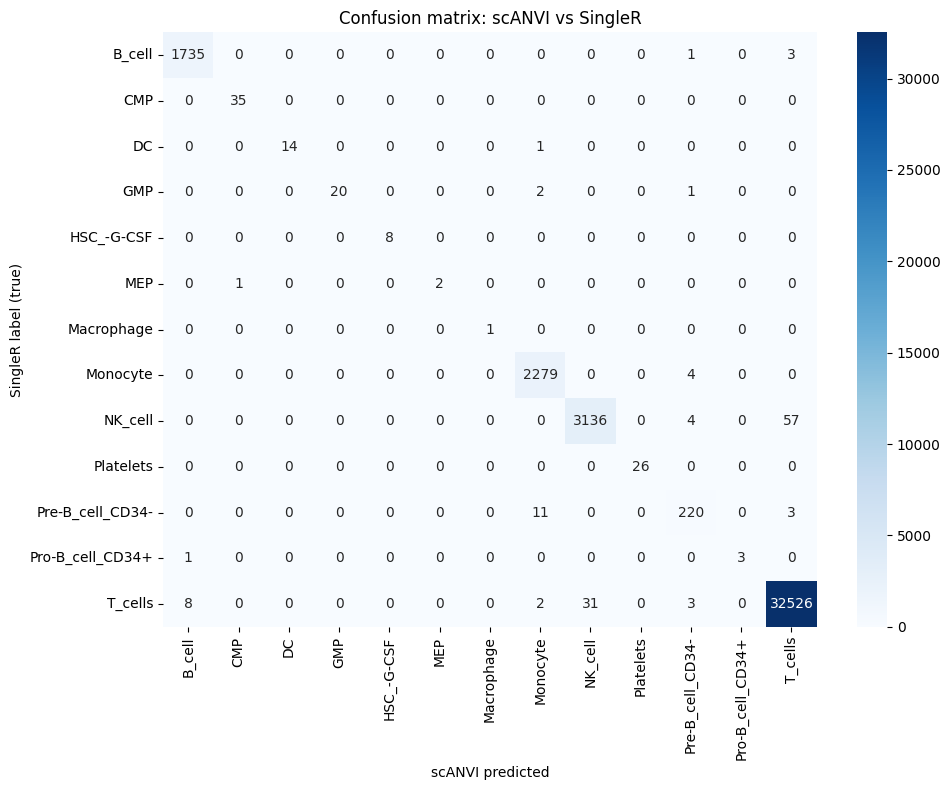

<Figure size 640x480 with 0 Axes>

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_true = adata.obs["cell_type"]
y_pred = adata.obs["scanvi_labels"]

cm = confusion_matrix(y_true, y_pred, labels=sorted(set(y_true)))
cm_df = pd.DataFrame(cm, index=sorted(set(y_true)), columns=sorted(set(y_pred)))


plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("scANVI predicted")
plt.ylabel("SingleR label (true)")
plt.title("Confusion matrix: scANVI vs SingleR")
plt.tight_layout()
plt.show()
plt.savefig("confusion_matrix_scanvi_vs_singler.png", dpi=300)

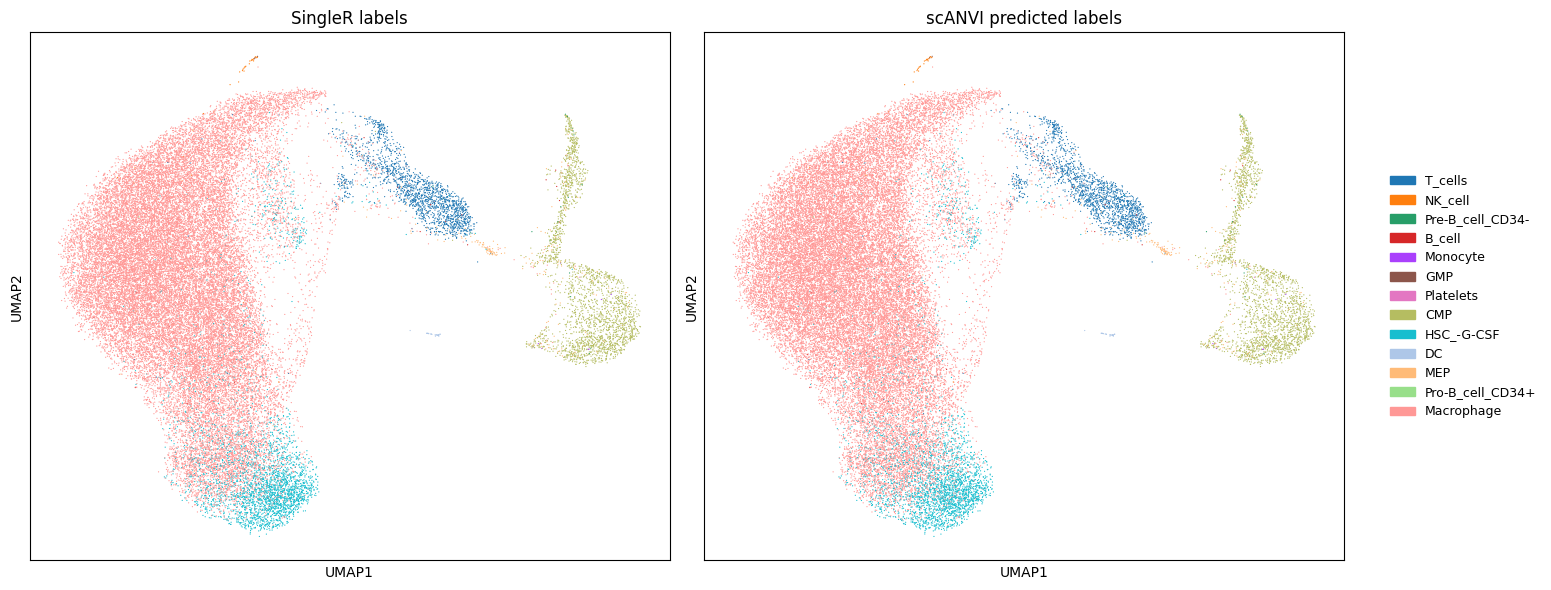

In [14]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np


label_key1 = "cell_type"         # SingleR 标签
label_key2 = "scanvi_labels"     # scANVI 标签


labels = adata.obs[label_key1].unique().tolist()
colors = adata.uns[f"{label_key1}_colors"]  # scanpy 自动存储的颜色顺序


fig, axs = plt.subplots(1, 3, figsize=(16, 6), gridspec_kw={'width_ratios': [4, 4, 1]})


sc.pl.umap(
    adata,
    color=label_key1,
    ax=axs[0],
    title="SingleR labels",
    show=False,
    legend_loc=None
)

# 2️⃣ scANVI 
sc.pl.umap(
    adata,
    color=label_key2,
    ax=axs[1],
    title="scANVI predicted labels",
    show=False,
    legend_loc=None
)


patches = [
    mpatches.Patch(color=colors[i], label=labels[i])
    for i in range(len(labels))
]

axs[2].axis("off")
axs[2].legend(handles=patches, loc="center left", frameon=False, fontsize=9)


plt.tight_layout()
plt.savefig("umap_singler_scanvi_comparison.png", dpi=300)  # 也可改为 pdf
plt.show()


In [15]:
adata.obs[["scanvi_labels"]].to_csv("scanvi_labels.csv")